In [1]:
import tensorflow as tf 
import tensorflow.keras
import import_ipynb
from regular import classifier_creation, loader
import numpy as np
import matplotlib.pyplot as plt
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
import time
import os
import sys
import h5py
import glob
import cv2
print(len(tf.config.list_physical_devices('GPU')) > 0)

c:\Users\joshu\.conda\envs\ethics\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


importing Jupyter notebook from regular.ipynb
True
Currently Opening
Loading


100%|██████████| 3434/3434 [00:23<00:00, 147.56it/s]


Regular Classifier Accuracy: 0.9960
True


Creating the loss function for a variational auto encoder

In [2]:
def vae_loss(x, x_reconstruction, mu, log_sigma, latent_wheight = 0.0005):
    loss_latent = (0.5) * tf.reduce_sum(tf.exp(log_sigma) + tf.square(mu) - 1.0 - log_sigma, axis=1)
    loss_reconstruction = tf.reduce_mean(tf.abs(x - x_reconstruction), axis=(1, 2, 3))
    net_loss = loss_reconstruction + (latent_wheight * loss_latent)
    return net_loss

Reparameterization trick in VAEs

In [3]:
def sampled_latent(z_mean, z_log_sigma):
    batch, latent_dim = z_mean.shape
    epsilon = tf.random.normal(shape=(batch, latent_dim))
    z = z_mean + tf.math.exp(0.5 * z_log_sigma) * epsilon
    return z

Creating The Debiased variational autoencoder

In [4]:
def db_vae_loss(x, x_prediction, y, y_logit, mu, log_sigma):
    loss_vae = vae_loss(x, x_prediction, mu, log_sigma)
    loss_class = tf.nn.sigmoid_cross_entropy_with_logits(y, y_logit)
    face_value = tf.cast(tf.equal(y, 1), tf.float32)
    net_loss = tf.reduce_mean(loss_class + (face_value * loss_vae))
    return net_loss, loss_class

Creating the DB-VAE decoder (Use the regular classifier as the encoder)

In [5]:
def decoder_creation():
    ConvTranspose = functools.partial(tensorflow.keras.layers.Conv2DTranspose, padding='same', activation='relu')
    Flatten = tensorflow.keras.layers.Flatten
    Dense = functools.partial(tensorflow.keras.layers.Dense, activation='relu')
    Reshape = tensorflow.keras.layers.Reshape

    decoder = tensorflow.keras.Sequential([
        Dense(units=4*4*6*12),
        Reshape(target_shape=(4, 4, 6*12)),
        ConvTranspose(filters=4*12, kernel_size=3,  strides=2),
        ConvTranspose(filters=2*12, kernel_size=3,  strides=2),
        ConvTranspose(filters=1*12, kernel_size=5,  strides=2),
        ConvTranspose(filters=3, kernel_size=5,  strides=2),
    ])

    return decoder

Creating the actual DB-VAE

In [6]:
class DeBiasedVariationalAutoEncoder(tensorflow.keras.Model):
    def __init__(self, z_dim):
        super(DeBiasedVariationalAutoEncoder, self).__init__()
        self.z_dim = z_dim
        encoder_dims = (2 * self.z_dim) + 1
        self.encoder = classifier_creation(encoder_dims)
        self.decoder = decoder_creation()

    def encode(self, x):
        encoded = self.encoder(x)
        y_logit = tf.expand_dims(encoded[:, 0], -1)
        z_mean = encoded[:, 1:self.z_dim+1] 
        z_log_sigma = encoded[:, self.z_dim+1:]
        return y_logit, z_mean, z_log_sigma

    def reparameterize_trick(self, z_mean, z_log_sigma):
        z = sampled_latent(z_mean, z_log_sigma)
        return z

    def decode(self, z):
        reconstruction = self.decoder(z)
        return reconstruction
    
    def call(self, x):
        y_logit, z_mean, z_log_sigma = self.encode(x)
        z = self.reparameterize_trick(z_mean, z_log_sigma)
        reconstruction = self.decode(z)
        return y_logit, z_mean, z_log_sigma, reconstruction
    
    def predict(self, x):
        y_logit, z_mean, z_logsigma = self.encode(x)
        return y_logit

Perform Adaptive Resampling For Automated Debiasing in a debiased variational autoencoder

Getting the Latent variable means

In [7]:
def get_latent_var_means(imgs, db_vae, batch_size):
    N = imgs.shape[0]
    mu = np.zeros((N, 100))
    for idx in range(0, N, batch_size):
        last_idx = min(idx + batch_size, N + 1)
        batch = (imgs[idx:last_idx]).astype(np.float32)/255.
        _, B_mu, _ = db_vae.encode(batch)
        mu[idx:last_idx] = B_mu
    return mu

Creating the Actual Adaptive Resampling Algorithm

In [8]:
def get_sample_probs(imgs, db_vae, smoothing=0.001): # the Lower smoothing is, the more it will fall uniformly along the latent space
    mu = get_latent_var_means(imgs, db_vae, 1024)
    training_sample_probabilities = np.zeros(mu.shape[0])
    for i in range(100):
        distribution_of_latent_space = mu[:, i]
        density, bin_e = np.histogram(distribution_of_latent_space, density=True, bins=10)
        bin_e[0] = -float('inf')
        bin_e[-1] = float('inf')
        bin_idx = np.digitize(distribution_of_latent_space, bin_e)
        smooth_density = density + smoothing
        smooth_density = smooth_density / np.sum(smooth_density)
        prob = (1.0)/(smooth_density[bin_idx - 1])
        prob = prob/np.sum(prob)
        training_sample_probabilities = np.maximum(prob, training_sample_probabilities)
    training_sample_probabilities /= np.sum(training_sample_probabilities)
    return training_sample_probabilities

Define Hyperparameters for the DB-VAE's training

In [9]:
batch_size = 32
lr = 1e-4
epochs = 6
db_vae = DeBiasedVariationalAutoEncoder(100)
opt = tensorflow.keras.optimizers.Adam(lr)

In [10]:
def plot(x, y, db_vae):
    plt.figure(figsize=(2, 1))
    plt.subplot(1, 2, 1)
    idx = np.where(y==1)[0][0]
    plt.imshow(x[idx])
    plt.grid(False)

    plt.subplot(1, 2, 2)
    _, _, _, reconstruction = db_vae(x)
    reconstruction = np.clip(reconstruction, 0, 1)
    plt.imshow(reconstruction[idx])
    plt.grid(False)

    plt.show()

In [11]:
@tf.function
def db_train_step(x, y):
    with tf.GradientTape() as tape:
        y_logit, z_mean, z_log_sigma, reconstruction = db_vae(x)
        loss, classification_loss = db_vae_loss(x, reconstruction, y, y_logit, z_mean, z_log_sigma)
    gradients = tape.gradient(loss, db_vae.trainable_variables)
    opt.apply_gradients(zip(gradients, db_vae.trainable_variables))
    return loss

faces = loader.all_faces()

def training_loop_db():
    for epoch in range(epochs):
        ipythondisplay.clear_output(wait=True)
        print("Epoch {}/{}".format(epoch + 1, epochs))
        sampling_probs = get_sample_probs(faces, db_vae)
        for i in tqdm(range(loader.size() // batch_size)):
            (x, y) = loader.gen_batch(batch_size, p_positive=sampling_probs)
            loss = db_train_step(x, y)

            if i % 500 == 0:
                plot(x, y, db_vae)

Epoch 6/6


  0%|          | 0/3434 [00:00<?, ?it/s]

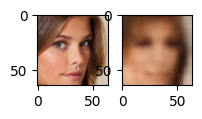

 14%|█▍        | 494/3434 [00:04<00:23, 127.45it/s]

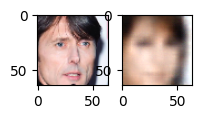

 29%|██▉       | 999/3434 [00:08<00:23, 104.59it/s]

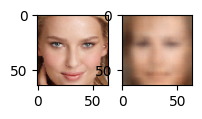

 44%|████▎     | 1497/3434 [00:13<00:15, 125.32it/s]

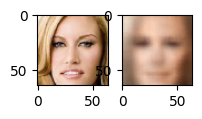

 58%|█████▊    | 2000/3434 [00:17<00:12, 114.42it/s]

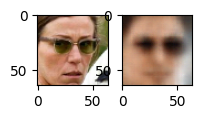

 73%|███████▎  | 2492/3434 [00:22<00:08, 114.40it/s]

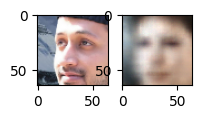

 87%|████████▋ | 2995/3434 [00:26<00:03, 120.20it/s]

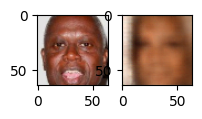

100%|██████████| 3434/3434 [00:30<00:00, 113.83it/s]


In [12]:
training_loop_db()

In [33]:
import PIL
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[150:150 + 64, 250:250 + 64, :]
    cv2.imshow("Are you a human?", frame)
    if cv2.waitKey(1) == ord('c'):
        cv2.imwrite('test.jpg', frame)
    if cv2.waitKey(1) == ord('x'):
        cv2.imwrite('test2.jpg', frame)
    if cv2.waitKey(1) == ord('v'):
        cv2.imwrite('test3.jpg', frame)
    if cv2.waitKey(1) == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

You are Human
You are not Human
You are Human


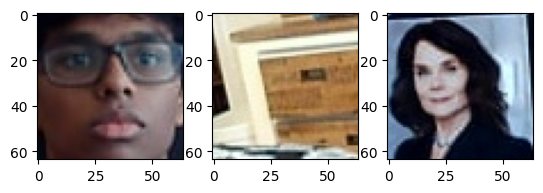

In [36]:
img1 = PIL.Image.open("test.jpg")
img1.resize((64, 64))
img_arr1 = np.array(img1)
test_img1 = np.zeros((1, 64, 64, 3))
test_img1[0] = img_arr1
print("You are Human" if db_vae.predict(test_img1) > 0 else "You are not Human")
img2 = PIL.Image.open("test2.jpg")
img2.resize((64, 64))
img_arr2 = np.array(img2)
test_img2 = np.zeros((1, 64, 64, 3))
test_img2[0] = img_arr2
print("You are Human" if db_vae.predict(test_img2) > 0 else "You are not Human")
img3 = PIL.Image.open("test3.jpg")
img3.resize((64, 64))
img_arr3 = np.array(img3)
test_img3 = np.zeros((1, 64, 64, 3))
test_img3[0] = img_arr3
print("You are Human" if db_vae.predict(test_img3) > 0 else "You are not Human")
f = plt.figure()
f.add_subplot(1,3, 1)
plt.imshow(img_arr1)
f.add_subplot(1,3, 2)
plt.imshow(img_arr2)
f.add_subplot(1,3, 3)
plt.imshow(img_arr3)
plt.show(block=True)